Exercise 9-1:As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real.
Conversely, as sample size decreases, the test is less likely to be positive even
if the effect is real.

In [8]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

In [9]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [22]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [26]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [30]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

Defining the dataframe

In [31]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [32]:

def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [33]:
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

9148	0.16	0.00	0.00	0.00
4574	0.23	0.00	0.00	0.00
2287	0.46	0.01	0.02	0.00
1143	0.34	0.01	0.00	0.21
571	0.87	0.33	0.03	0.64
285	0.58	0.18	0.00	0.11
142	0.17	0.96	0.65	0.34


In [ ]:
# Solution

# My results:

# test1: difference in mean pregnancy length
# test2: difference in mean birth weight
# test3: correlation of mother's age and birth weight
# test4: chi-square test of pregnancy length

# n       test1   test2   test2   test4
# 9148	0.16	0.00	0.00	0.00
# 4574	0.23	0.00	0.00	0.00
# 2287	0.46	0.01	0.00	0.00
# 1143	0.34	0.01	0.00	0.21
# 571	0.87	0.33	0.03	0.64
# 285	0.58	0.18	0.00	0.11
# 142	0.17	0.96	0.65	0.34

# Conclusion: As expected, tests that are positive with large sample
# sizes become negative as we take away data.  But the pattern is not consistent
# erratic, with some positive tests even at small sample sizes.


Exercise 10-1:Using the data from the BRFSS, compute the linear least
squares fit for log(weight) versus height. How would you best present the
estimated parameters for a model like this where one of the variables is logtransformed? If you were trying to guess someone’s weight, how much would
it help to know their height?

In [34]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimating the intercept and slope or gradient

In [35]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163918104, 0.005281454169417819)

Making a scatter plot of the data and show the fitted line (line of best fit)

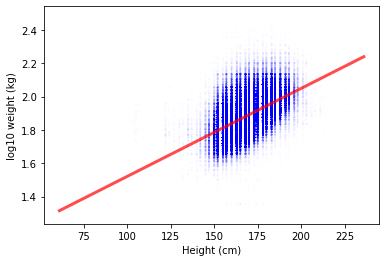

In [36]:
# Solution

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

One of the variables is log transformed ()

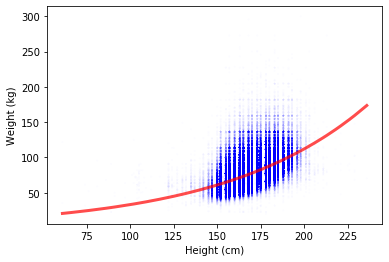

In [37]:
# Solution

thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

A way to measure goodness of fit is the coefficient of determination, usually denoted R2 and called “R-squared”:
Another way is to compute the standard deviation of the residuals

In [49]:
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

Computing correlation.

In [50]:
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983443

Computing coefficient of determination.(r-squared)

In [55]:
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311894065

In [ ]:
Confirm that  𝑅2=𝜌2 .

In [56]:
rho**2 - r2

1.1102230246251565e-16

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [45]:


std_ys = thinkstats2.Std(log_weights)
std_ys

0.103207250300049

Compute Std(res), the RMSE of predictions that do use height.

In [58]:
#Std(res) is the best representation of the quality of prediction

std_res = thinkstats2.Std(res)
std_res

0.0874077708041609

How much does height information reduce RMSE?

In [57]:


1 - std_res / std_ys

0.15308497658793452

Using resampling, with and without weights, to estimate
the mean height of respondents in the BRFSS, the standard error of the
mean, and a 90% confidence interval. How much does correct weighting
affect the estimates?

In [59]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plotting the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

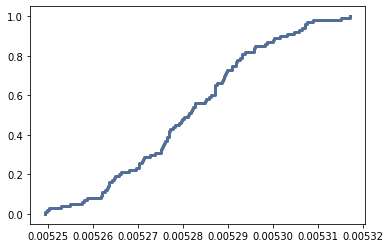

In [60]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Computing the p-value of the slope.

In [61]:
pvalue = cdf[0]
pvalue

0

Computing the 90% confidence interval of slope.

In [62]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005254910908099908, 0.005307073949755889)

Computing the mean of the sampling distribution.

In [63]:
mean = thinkstats2.Mean(slopes)
mean

0.005281225359611188

Computing the standard deviation of the sampling distribution, which is the standard error.

In [64]:
stderr = thinkstats2.Std(slopes)
stderr

1.5247390239411296e-05

Resampling rows without weights, compute mean height, and summarize results.

In [84]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

In [85]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [86]:
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [87]:
iters = 100
estimates = [ResampleRowsWeighted(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.349703064582355 0.013299474868016475 (7.326560081804113, 7.372424678777138)


In [88]:
estimates = [thinkstats2.ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

mean, SE, CI 7.265182830805148 0.016186987088426006 (7.234368089340999, 7.288573840363113)


In [89]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95910525172295 0.01774616615056842 (168.92745154509993, 168.98554437235998)


In [90]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.49591758624874 0.015548538552937663 (170.4669329412478, 170.52131207178803)


 The estimated mean height is almost 1 cm taller (170.50-168.96)
if we take into account the sampling weights,
and this difference is much bigger than the sampling error.